# Logistic Regression Modelling

In [341]:
# %pip install imbalanced-learn

In [342]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [343]:
df = pd.read_excel('Cleaned_Data.xlsx')
df

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Family_Size,Total_Spent,BuyingPower
0,0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,...,4,4,6,1,1,0,54,1,198.333333,0.002338
1,1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,...,7,3,7,5,1,0,63,1,96.166667,0.001684
2,2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,...,3,2,5,2,0,0,66,3,41.833333,0.000622
3,3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,...,1,0,2,7,0,0,57,4,1.833333,0.000056
4,4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,...,3,1,2,7,1,0,35,2,15.166667,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,2235,10142,1976,PhD,Divorced,66476.0,0,1,2013-07-03,99,...,5,2,11,4,0,0,48,2,114.833333,0.001727
2230,2236,5263,1977,TwoN_Cycle,Married,31056.0,1,0,2013-01-22,99,...,1,0,3,8,0,0,47,3,9.166667,0.000295
2231,2237,22,1976,Graduation,Divorced,46310.0,1,0,2012-03-12,99,...,6,1,5,8,0,0,48,2,51.500000,0.001112
2232,2238,528,1978,Graduation,Married,65819.0,0,0,2012-11-29,99,...,5,4,10,3,0,0,46,2,230.500000,0.003502


In [344]:
selected_columns = [
    'Age',
    'Marital_Status',
    'Education',
    'Income', 
    'Kidhome', 
    'Teenhome',
    'Recency',
    # 'Dt_Customer',
    # 'MntFishProducts', 
    'MntMeatProducts', 
    # 'MntFruits', 
    # 'MntSweetProducts', 
    'MntWines', 
    # 'MntGoldProds',
    'NumDealsPurchases',
    # 'NumWebPurchases',
    # 'NumCatalogPurchases',
    # 'NumStorePurchases',
    # 'NumWebVisitsMonth',
    'Family_Size',
    # 'Total_Spent',
    # 'BuyingPower',
    'Response',
    # 'Complain'
]
df = df[selected_columns]

In [345]:
def one_hot_encode(data, column, suffix=''):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded, lsuffix='_data', rsuffix='_encoded')
    # data = data.join(encoded)
    return data
df = one_hot_encode(df, 'Marital_Status')
df = one_hot_encode(df, 'Education')

# from sklearn.calibration import LabelEncoder


# le_Education = LabelEncoder()
# le_Marital_Status = LabelEncoder()

# df['Marital_Status'] = le_Marital_Status.fit_transform(df['Marital_Status'])
# df['Education'] = le_Education.fit_transform(df['Education'])

# df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')
df

,Age,Income,Kidhome,Teenhome,Recency,MntMeatProducts,MntWines,NumDealsPurchases,Family_Size,Response,Married,Single,Together,Widow,Graduation,Master,PhD,TwoN_Cycle
0,54,84835.0,0,0,0,379,189,1,1,1,False,False,False,False,True,False,False,False
1,63,57091.0,0,0,0,64,464,1,1,1,False,True,False,False,True,False,False,False
2,66,67267.0,0,1,0,59,134,1,3,0,True,False,False,False,True,False,False,False
3,57,32474.0,1,1,0,1,10,1,4,0,False,False,True,False,True,False,False,False
4,35,21474.0,1,0,0,24,6,2,2,1,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,48,66476.0,0,1,99,126,372,2,2,0,False,False,False,False,False,False,True,False
2230,47,31056.0,1,0,99,13,5,1,3,0,True,False,False,False,False,False,False,True
2231,48,46310.0,1,0,99,88,185,2,2,0,False,False,False,False,True,False,False,False
2232,46,65819.0,0,0,99,701,267,1,2,0,True,False,False,False,True,False,False,False


In [346]:
# sample = df[~(df['Single'] | df['Married'] | df['Together'] | df['Widow'])]
# sample

In [347]:
from scipy import stats


z_age = np.abs(stats.zscore(df['Age']))
z_income = np.abs(stats.zscore(df['Income']))
# z_buying_power = np.abs(stats.zscore(df['BuyingPower']))
threshold_z = 3


print("Original DataFrame Shape:", df.shape)
age_outlier_indices = np.where(z_age > threshold_z)[0]
income_outlier_indices = np.where(z_income > threshold_z)[0]
# income_buying_power = np.where(z_income > threshold_z)[0]

outlier_indices = np.array(list(set(age_outlier_indices) | set(income_outlier_indices)))

df = df.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", df.shape)
# df

Original DataFrame Shape: (2234, 18)
DataFrame Shape after Removing Outliers: (2223, 18)


In [348]:
X = df.drop('Response', axis=1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


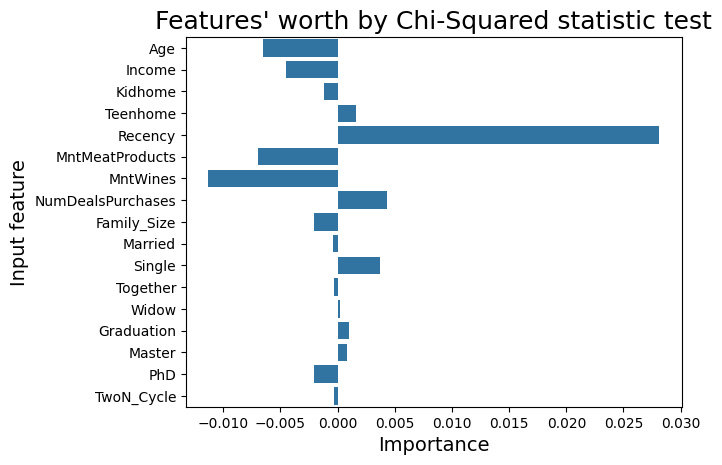

Recency: 0.028135932033983055
NumDealsPurchases: 0.004347826086956567
Single: 0.003698150924537765
Teenhome: 0.0015992003998001269
Graduation: 0.0009995002498750737
Master: 0.0008495752123937975
Widow: 0.00019990004997501033
TwoN_Cycle: -0.00029985007496251547
Together: -0.00034982508745625324
Married: -0.00039980009994999843
Kidhome: -0.0011994002998500398
Family_Size: -0.002048975512243852
PhD: -0.0020989505247376084
Income: -0.004547726136931492
Age: -0.006496751624187868
MntMeatProducts: -0.006996501749125405
MntWines: -0.011294352823588172


In [349]:
# Create a ColumnTransformer for scaling
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline


# Define a ColumnTransformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ])

# Use a pipeline to include the preprocessing step and the logistic regression model
pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)

# Now, use the pipeline for permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

feature_importances = result.importances_mean
feature_indices = np.argsort(feature_importances)[::-1]

sns.barplot(y=X.columns, x=feature_importances)
plt.title("Features' worth by Chi-Squared statistic test", fontsize=18)
plt.ylabel("Input feature", fontsize=14)
plt.xlabel("Importance", fontsize=14)

plt.show()

# Print feature importance ranking
for idx in feature_indices:
    print(f"{X.columns[idx]}: {feature_importances[idx]}")

In [350]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)

clf = LogisticRegression(random_state=0)

In [351]:
# # Hyperparameter checking

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2']
}

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=1),
    'recall': make_scorer(recall_score, zero_division=1),
    'f1': make_scorer(f1_score, zero_division=1),
    'auc': make_scorer(roc_auc_score, needs_proba=True)
}

grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=5, refit='f1')

# # Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

from sklearn.model_selection import StratifiedKFold

# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)
# dahil mataas yung C value wala masyadong regularization na nagaganap therefore di nagooverfit yung model

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Hyperparameters: {'C': 10, 'penalty': 'l2'}


In [352]:
# clf = LogisticRegression(random_state=0, C=best_params['C'], penalty=best_params['penalty'])
clf.fit(X_train_resampled, y_train_resampled)
train_preds = clf.predict(X_train_resampled)
preds = clf.predict(scaler.transform(X_test))

## Train Scores

In [353]:
acc = accuracy_score(y_train_resampled, train_preds)
prec = precision_score(y_train_resampled, train_preds)
rec = recall_score(y_train_resampled, train_preds)
f1 = f1_score(y_train_resampled, train_preds)
auc = roc_auc_score(y_train_resampled, train_preds)

In [354]:
print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

Accuracy: 0.7440
Precision: 0.7403
Recall: 0.7515
F1: 0.7459
AUC: 0.7440


## Test Scores

In [355]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, preds)

In [356]:
print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

Accuracy: 0.7676
Precision: 0.3571
Recall: 0.7071
F1: 0.4746
AUC: 0.7426


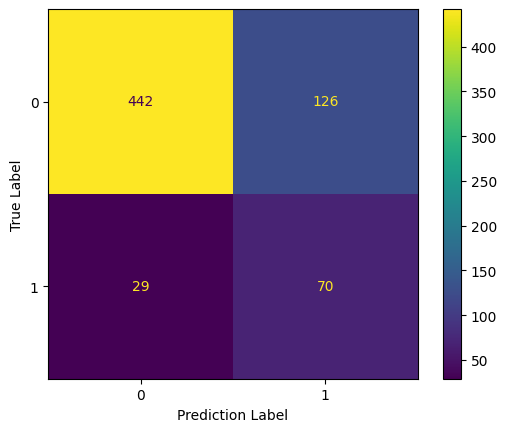

In [357]:
cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
# plt.title('Did the customer say yes?')
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.show()